In [1]:
%matplotlib inline
import matplotlib


In [36]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [3]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3

In [4]:
dataset = np.load('../datasets/car_64.npy')


1553596416


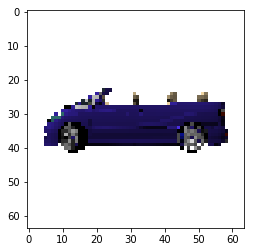

In [5]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [6]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [7]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [8]:
del dataset
dataset_train.nbytes

1242611712

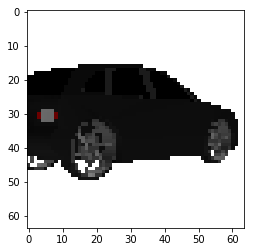

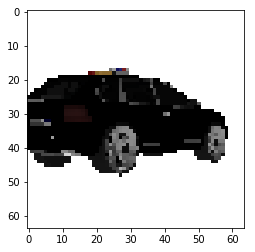

In [9]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [180]:
train_pairs = []
start_pose = [9]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [9]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [181]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 9, 0)
(1, 9, 0)
(2076, 9, 21)
(316, 9, 19)


(981, 9, 13)
(393, 9, 15)
98315


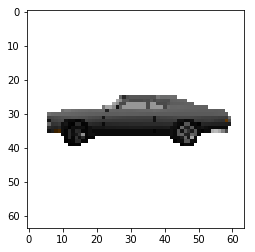

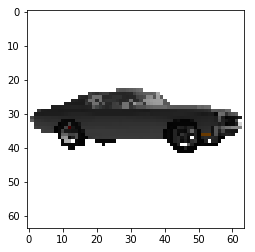

In [185]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(45*36) + 27]
j = dataset_train[(45*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [186]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [187]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

0


In [141]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
#         cur_pose =  np.zeros(36, dtype='uint8')
#         cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
#         pose.append(np.broadcast_to(cur_pose,(8,8,36)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
#     pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels

batch, batch_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3)
<class 'numpy.float64'>
1.0 -1.0


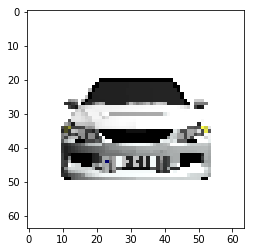

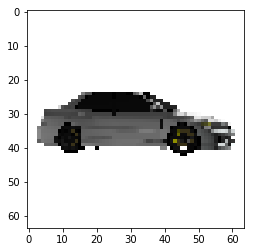

In [119]:
print(batch.shape, batch_labels.shape)

# t = 27
# print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [142]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [143]:
#definition of my layers


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=None):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))


def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=None):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation_fn=act)
    
    
def loss_(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss


In [144]:


batch_size = 36
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")

In [145]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Conv + relu  + Conv + relu  
# After 3 Convolution ,we will have a latent space
ae_reuse= False
def AutoEncoder(inputs_):
        global ae_reuse

        
        with tf.variable_scope('encoder', reuse=ae_reuse):
            ae_reuse = True
            conv1 = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1")
            tanh1 = tf.nn.relu(conv1)
            conv2 = conv2d(tanh1, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2")
            tanh2 = tf.nn.relu(conv2)
            conv3 = conv2d(tanh2, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3")
            tanh3 = tf.nn.relu(conv3)
            
            deconv1 = deconv2d(tanh3, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1')
            tanh4 = tf.nn.relu(deconv1)
            deconv2 = deconv2d(tanh4, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2')
            tanh5 = tf.nn.relu(deconv2)
            deconv3 = deconv2d(tanh5, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3')
            tanh6 = tf.nn.tanh(deconv3)
        return tanh6
        



In [146]:
global_step = tf.Variable(0,trainable=False)
learning_rate = 5e-4
decay_steps = 1000
decay_rate = 0.96

In [147]:
#calculate loss
tanh6 = AutoEncoder(inputs_)
loss_op = loss_(tanh6,targets_)

#Optimizer
# global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)

In [148]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 5
total_images = len(train_pairs)
step = 0

r = total_images // batch_size

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        
        pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels = get_batch_data(pairs)
        
        feed_dict = {inputs_: batch, targets_: batch_labels}
        _, loss = sess.run([train_op, loss_op], feed_dict = feed_dict)
        
        
        if step % 1000 == 0:
            print('Step {0}: loss = {1:.4f}'.format(step, loss))
            
    print('Epoch {0}: loss = {1:.4f}'.format(epoch, loss))

Step 1000: loss = 0.1950
Step 2000: loss = 0.1592
Epoch 0: loss = 0.1729
Step 3000: loss = 0.1896
Step 4000: loss = 0.1807
Step 5000: loss = 0.1540
Epoch 1: loss = 0.1714
Step 6000: loss = 0.1700
Step 7000: loss = 0.1699
Step 8000: loss = 0.1777
Epoch 2: loss = 0.1709
Step 9000: loss = 0.1823
Step 10000: loss = 0.1739
Epoch 3: loss = 0.1705
Step 11000: loss = 0.1636
Step 12000: loss = 0.1707
Step 13000: loss = 0.1508
Epoch 4: loss = 0.1703


In [188]:
t_pairs = test_pairs[3 * batch_size : 4 * batch_size]
test_batch, test_labels = get_batch_data(t_pairs, False)

In [189]:
feed_dict = { inputs_: test_batch}
op = sess.run([tanh6], feed_dict = feed_dict)

In [190]:
j = 20
op = denormalize(op[0])

In [191]:
print(np.min(op), np.max(op))

2.07419 255.0


In [192]:
op = np.where(op < 0.0,0.0, op)

In [193]:
print(np.min(op), np.max(op))

2.07419 255.0


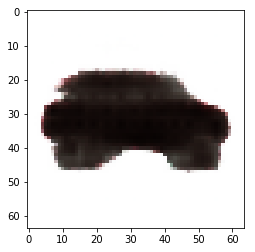

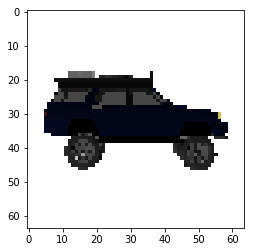

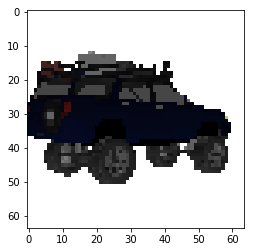

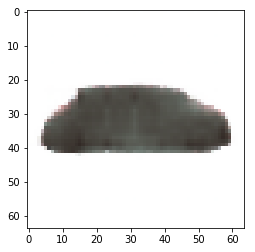

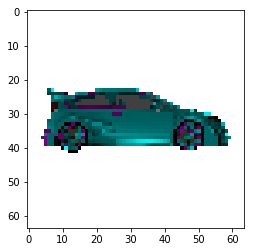

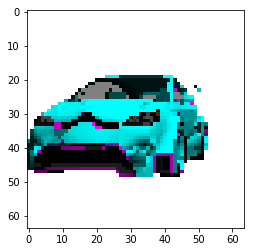

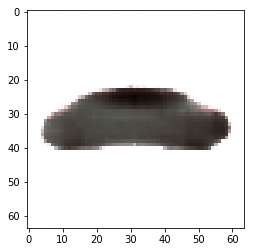

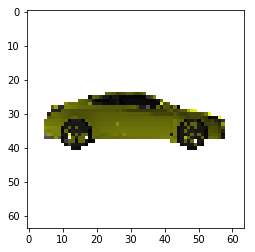

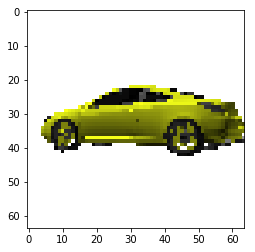

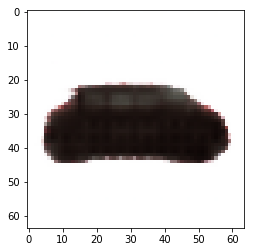

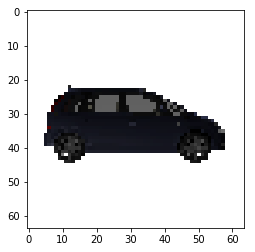

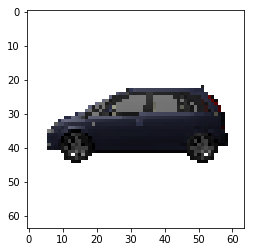

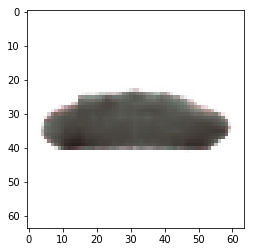

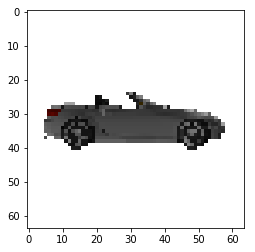

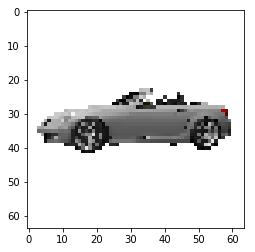

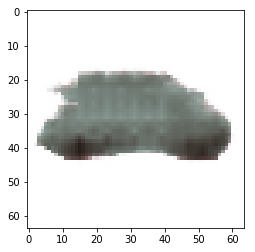

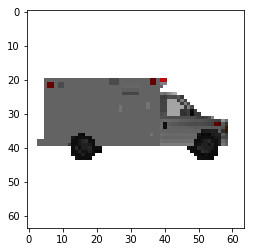

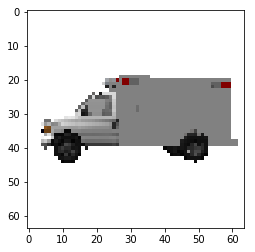

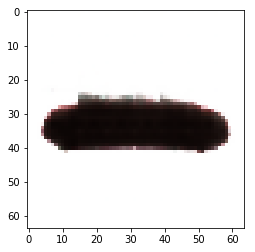

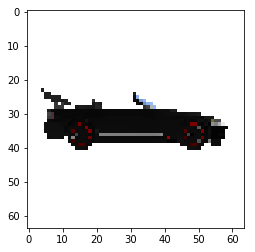

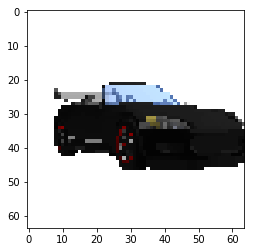

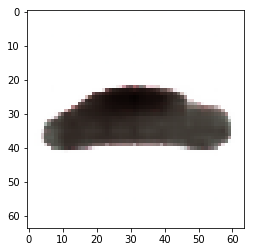

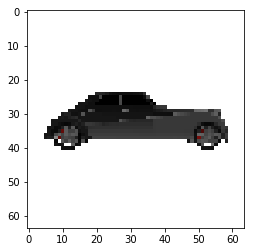

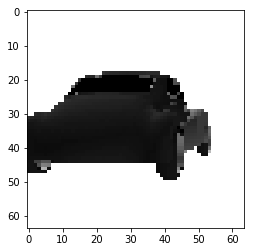

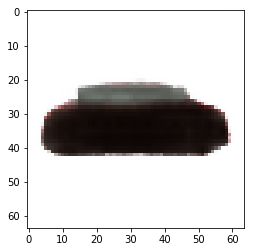

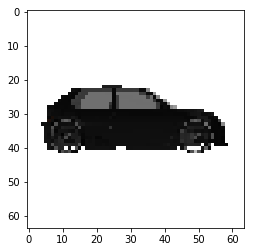

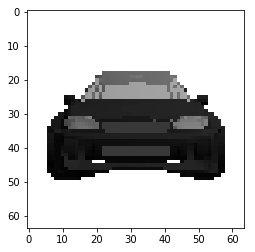

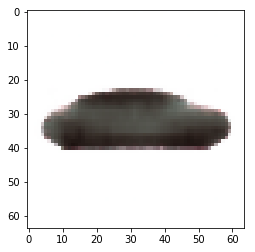

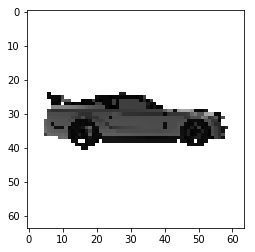

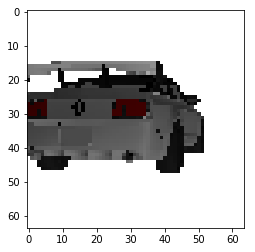

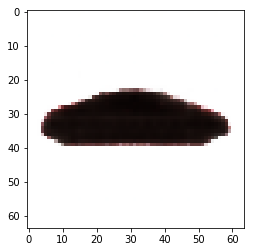

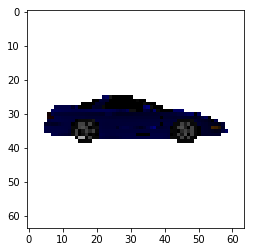

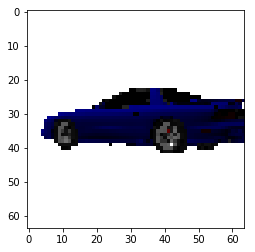

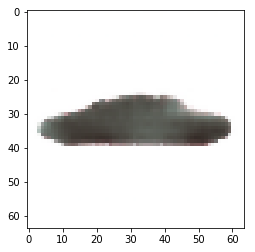

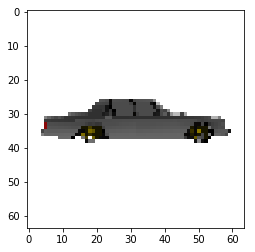

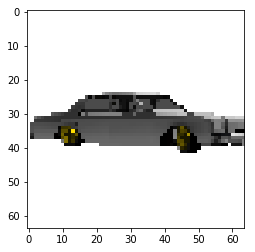

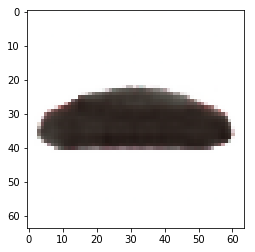

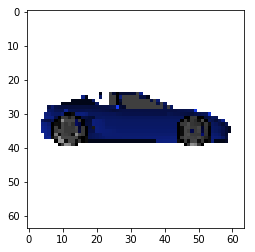

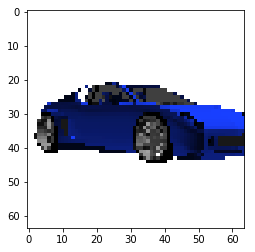

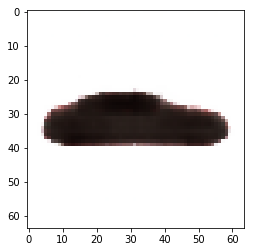

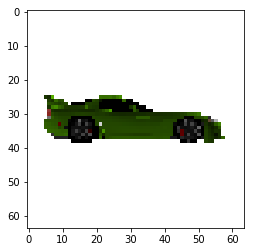

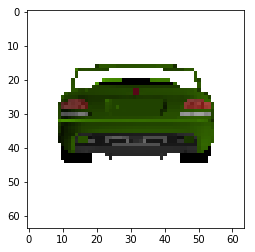

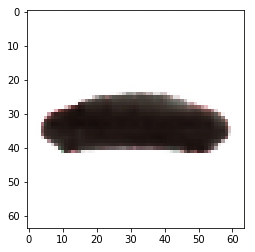

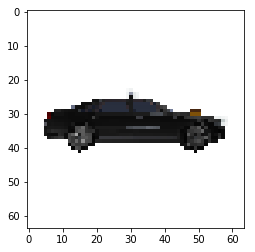

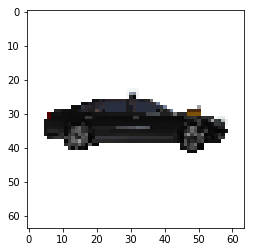

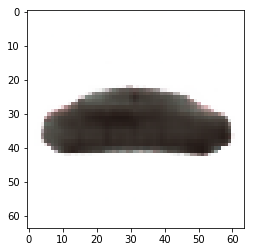

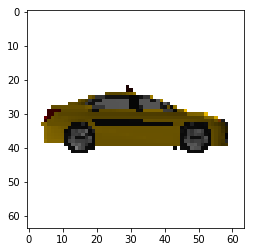

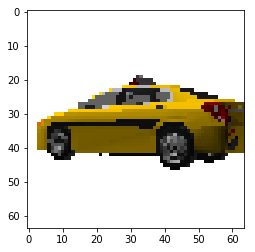

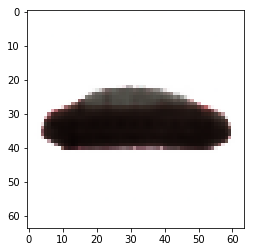

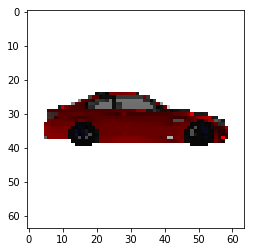

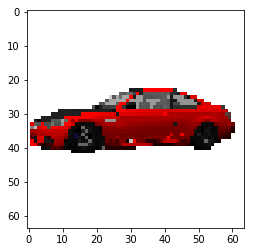

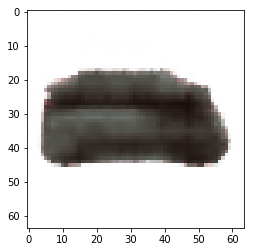

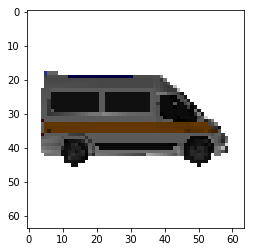

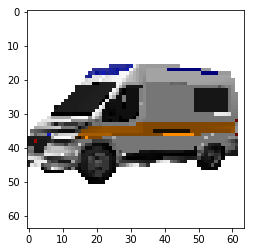

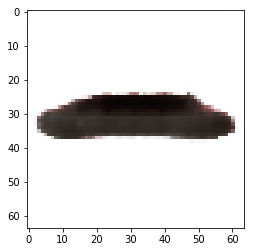

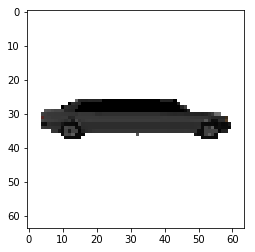

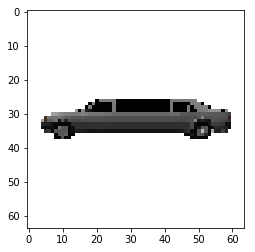

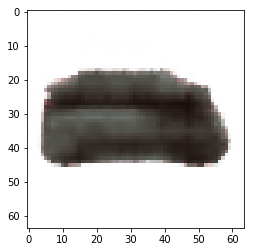

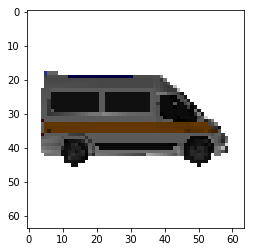

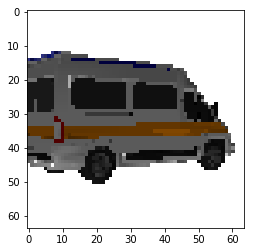

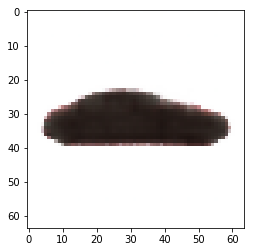

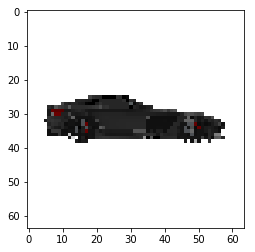

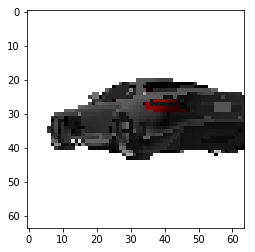

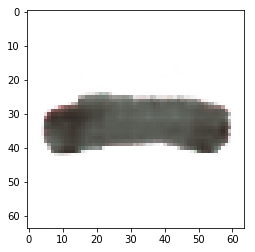

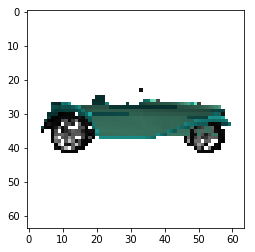

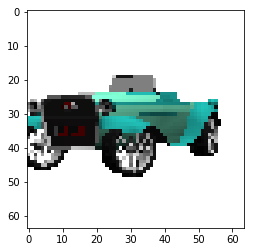

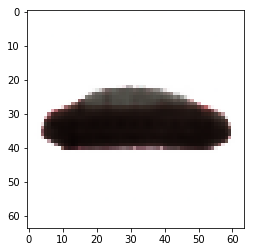

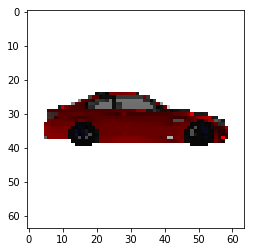

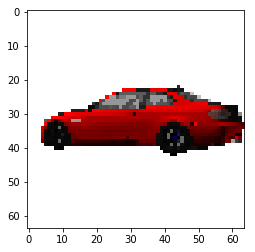

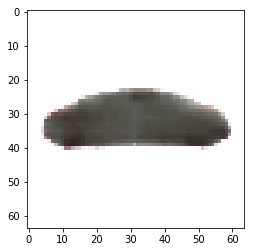

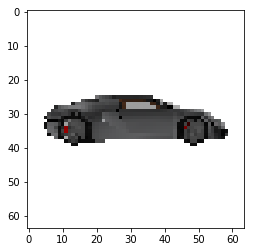

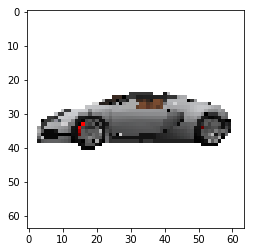

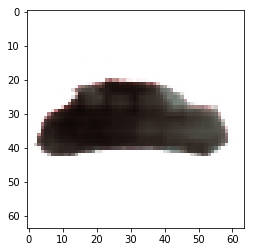

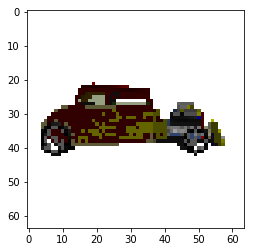

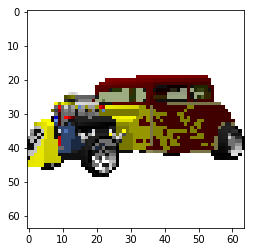

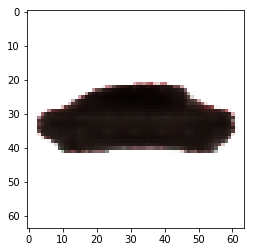

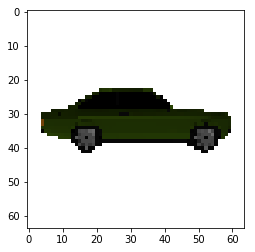

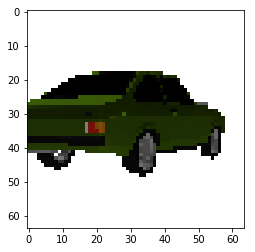

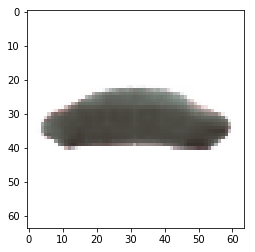

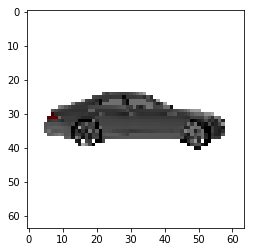

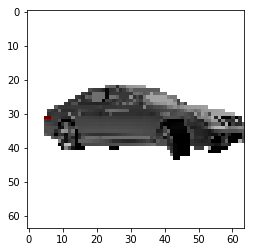

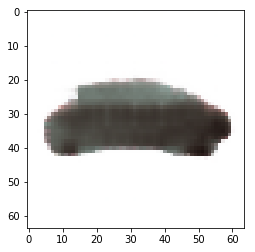

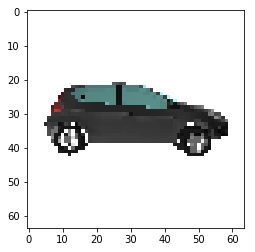

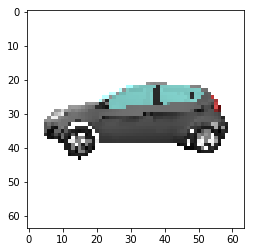

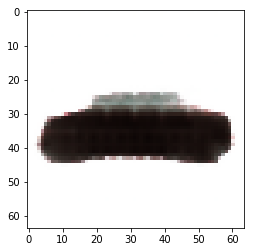

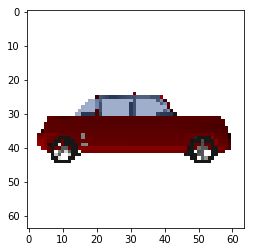

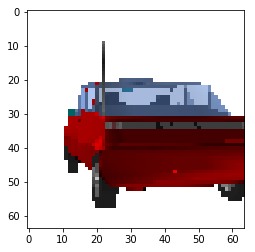

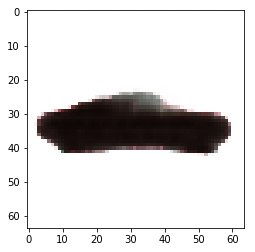

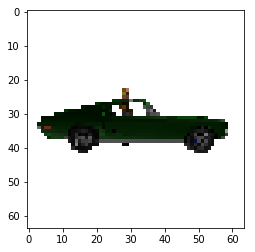

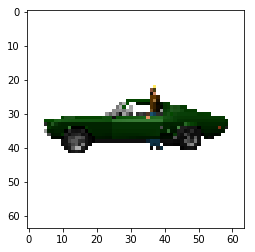

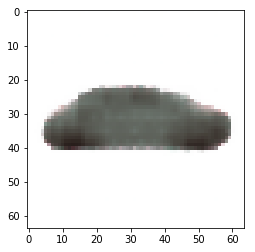

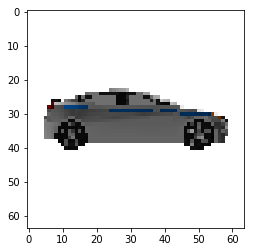

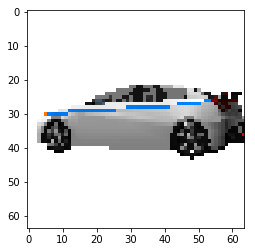

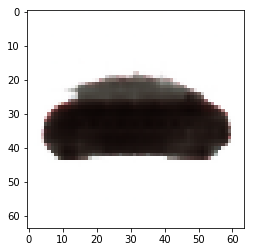

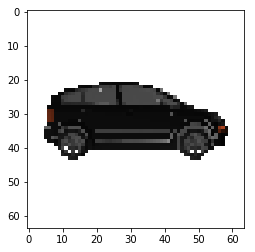

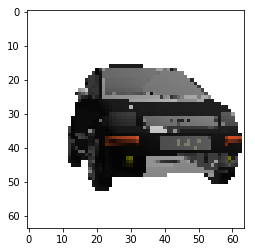

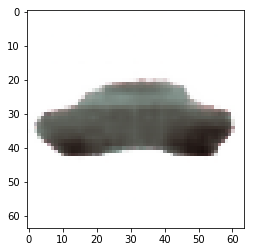

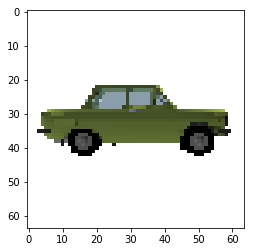

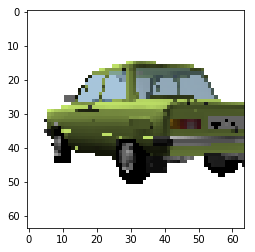

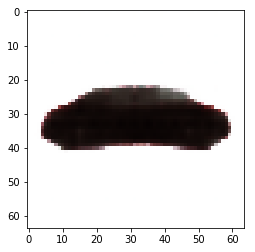

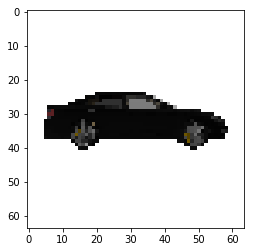

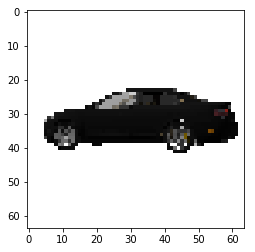

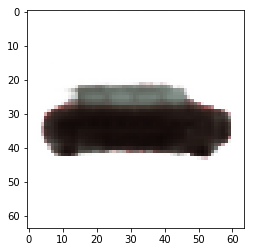

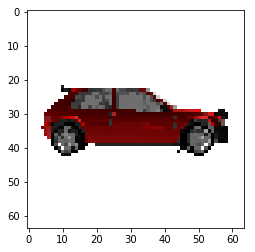

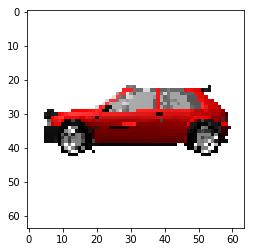

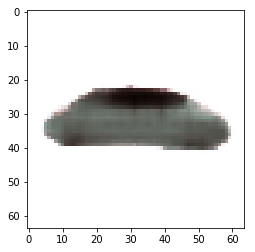

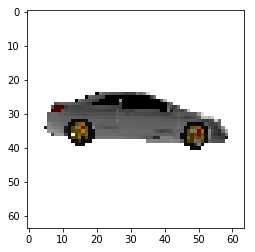

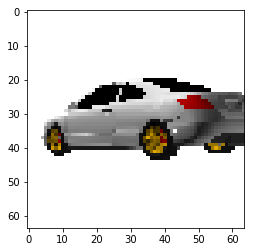

In [194]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()